# Preprocessing (CosmoMap PM-v1.6)

In [142]:
# Third-party imports,
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split

"""SPECIFICATIONS"""
input_UNITS = r"$M_{\odot}/h/(Mpc/h)^3$"
target1_UNITS = r"$h^2/cm^3$"
target2_UNITS = r"$K$"
input_QUANTITY = "Dark Matter Density"
target1_QUANTITY = "Electron Number Density"
target2_QUANTITY = "Gas Temperature"

"""HELPER FUNCTIONS"""
def extract_images(data_list, sims):

    extracted_images = []

    # Consider only particlular simulations,
    for sim_num in sims:

        # Looping through all redshifts,
        for i, data in enumerate(data_list):
            sim_images = data[sim_num]
            extracted_images.append(sim_images)

    # Converting to NumPy array,
    extracted_images = np.array(extracted_images)

    # Reshaping,
    extracted_images = extracted_images.reshape(-1, extracted_images.shape[2], extracted_images.shape[3])

    return extracted_images

def create_redshift_labels(redshifts, sims):

    extracted_redshifts = []
    for sim_num in sims:

        # Looping through all redshifts,
        for redshift in redshifts:
            
            # Creating labels,
            redshift_labels = redshift*np.ones(shape=(256,))

            # Appending labels,
            extracted_redshifts.append(redshift_labels)

    # Converting to NumPy array,
    extracted_redshifts = np.array(extracted_redshifts)

    # Reshaping,
    extracted_redshifts = extracted_redshifts.reshape(-1)

    return extracted_redshifts

def serialise_example(x, y, θ_spec):
    """Serialises an (X,Y) pair for effficient storage."""
    feature = {
        "X_data": tf.train.Feature(float_list=tf.train.FloatList(value=x.flatten())),
        "Y_data": tf.train.Feature(float_list=tf.train.FloatList(value=y.flatten())),
        "θ_spec": tf.train.Feature(float_list=tf.train.FloatList(value=θ_spec.flatten())),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_to_tfrecord(X, Y, θ_spec, filename):
    """Write the dataset to a file on the disk."""
    with tf.io.TFRecordWriter(filename) as writer:
        for i in range(len(X)):
            example = serialise_example(X[i], Y[i], θ_spec[i])
            writer.write(example)
    print(f"Saved: {filename}")


# Loading Data

In [ ]:
# Loading input data files,
X_z00 = np.load(r"..//CAMELs//N-body_CV//Grids_Mtot_Nbody_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')
X_z05 = np.load(r"..//CAMELs//N-body_CV//Grids_Mtot_Nbody_IllustrisTNG_CV_256_z=0.5.npy", mmap_mode='r')
X_z10 = np.load(r"..//CAMELs//N-body_CV//Grids_Mtot_Nbody_IllustrisTNG_CV_256_z=1.0.npy", mmap_mode='r')
X_z15 = np.load(r"..//CAMELs//N-body_CV//Grids_Mtot_Nbody_IllustrisTNG_CV_256_z=1.5.npy", mmap_mode='r')
X_z20 = np.load(r"..//CAMELs//N-body_CV//Grids_Mtot_Nbody_IllustrisTNG_CV_256_z=2.0.npy", mmap_mode='r')

# Loading target data files,
Y1_z00 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_Ne_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')
Y1_z05 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_Ne_IllustrisTNG_CV_256_z=0.5.npy", mmap_mode='r')
Y1_z10 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_Ne_IllustrisTNG_CV_256_z=1.0.npy", mmap_mode='r')
Y1_z15 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_Ne_IllustrisTNG_CV_256_z=1.5.npy", mmap_mode='r')
Y1_z20 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_Ne_IllustrisTNG_CV_256_z=2.0.npy", mmap_mode='r')

Y2_z00 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_T_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')
Y2_z05 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_T_IllustrisTNG_CV_256_z=0.5.npy", mmap_mode='r')
Y2_z10 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_T_IllustrisTNG_CV_256_z=1.0.npy", mmap_mode='r')
Y2_z15 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_T_IllustrisTNG_CV_256_z=1.5.npy", mmap_mode='r')
Y2_z20 = np.load(r"..//CAMELs//IllustrisTNG_CV//Grids_T_IllustrisTNG_CV_256_z=2.0.npy", mmap_mode='r')

"""SAMPLE DATA EXTRACTION"""

# PARAMETERS,
N_SIMS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
REDSHIFTS = [0, 0.5, 1, 1.5, 2]

# Extracting data,
X = extract_images(data_list=[X_z00, X_z05, X_z10, X_z15, X_z20], sims=N_SIMS)
Y1 = extract_images(data_list=[Y1_z00, Y1_z05, Y1_z10, Y1_z15, Y1_z20], sims=N_SIMS)
Y2 = extract_images(data_list=[Y2_z00, Y2_z05, Y2_z10, Y2_z15, Y2_z20], sims=N_SIMS)
redshift_labels = create_redshift_labels(redshifts=REDSHIFTS, sims=N_SIMS)

# Normalisation & Scaling

A Min-Max normalisation is used. In the code block below, we determine an arbitrary, but appropriate value for the minimum and maximum values of the dataset. For our mappings, it was found that $\rho_{min} = 10^{4}$, $\rho_{max} = 10^{17}$, $T_{min} = 10^{2}$, $T_{max} = 10^{9}$, $N_{e, min} = 10^{-9} $ and $N_{e, max} = 10^{-1}$.

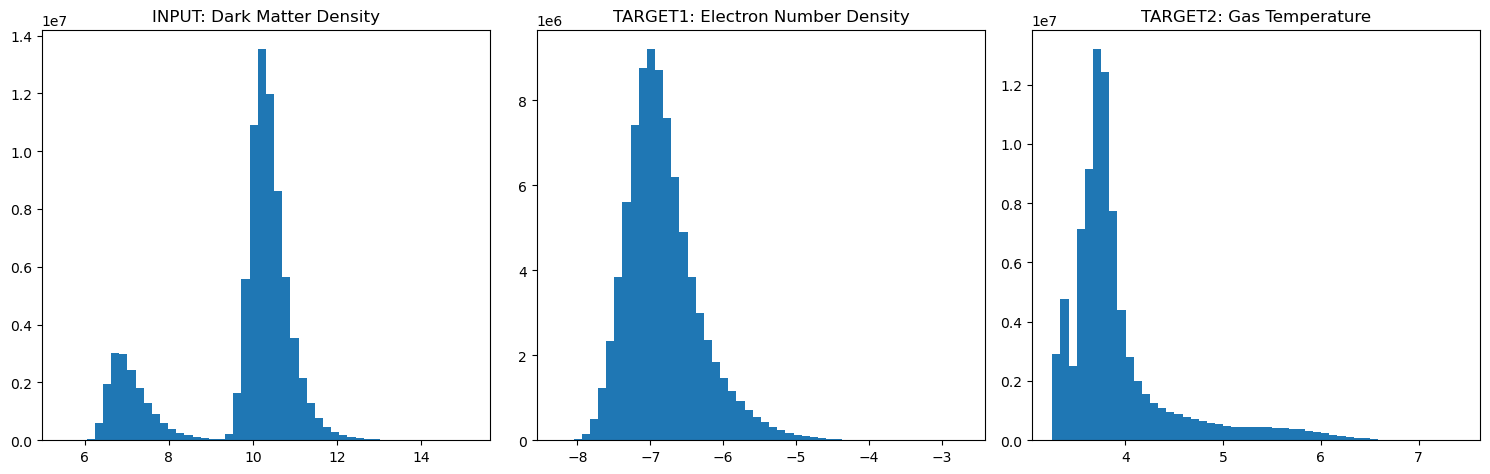

In [174]:
# Creating figure,
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

# For the X data,
N_BINS = 50
axes[0].hist(np.log10(X.flatten()), bins=N_BINS)
axes[0].set_title(f"INPUT: {input_QUANTITY}")
axes[1].hist(np.log10(Y1.flatten()), bins=N_BINS)
axes[1].set_title(f"TARGET1: {target1_QUANTITY}")
axes[2].hist(np.log10(Y2.flatten()), bins=N_BINS)
axes[2].set_title(f"TARGET2: {target2_QUANTITY}")

# Display plot,
plt.tight_layout()
plt.show()

Performing the scaling and normalisation,

In [147]:
# Functions,
def MinMaxNorm(data, min_val, max_val):
    return (data - min_val)/(max_val - min_val)

# Applying logarithmic transform,
X, Y1, Y2 = np.log10(X), np.log10(Y1), np.log10(Y2)

# Applying Min-Max normalisation,
X_min, X_max = 4, 17 #(DMD)
Y1_min, Y1_max = -9, -1 #(DMP-Ne)
Y2_min, Y2_max = 2, 9 #(DMP-T)

X, Y1, Y2 = MinMaxNorm(X, X_min, X_max), MinMaxNorm(Y1, Y1_min, Y1_max), MinMaxNorm(Y2, Y2_min, Y2_max)

# Data Visualiser

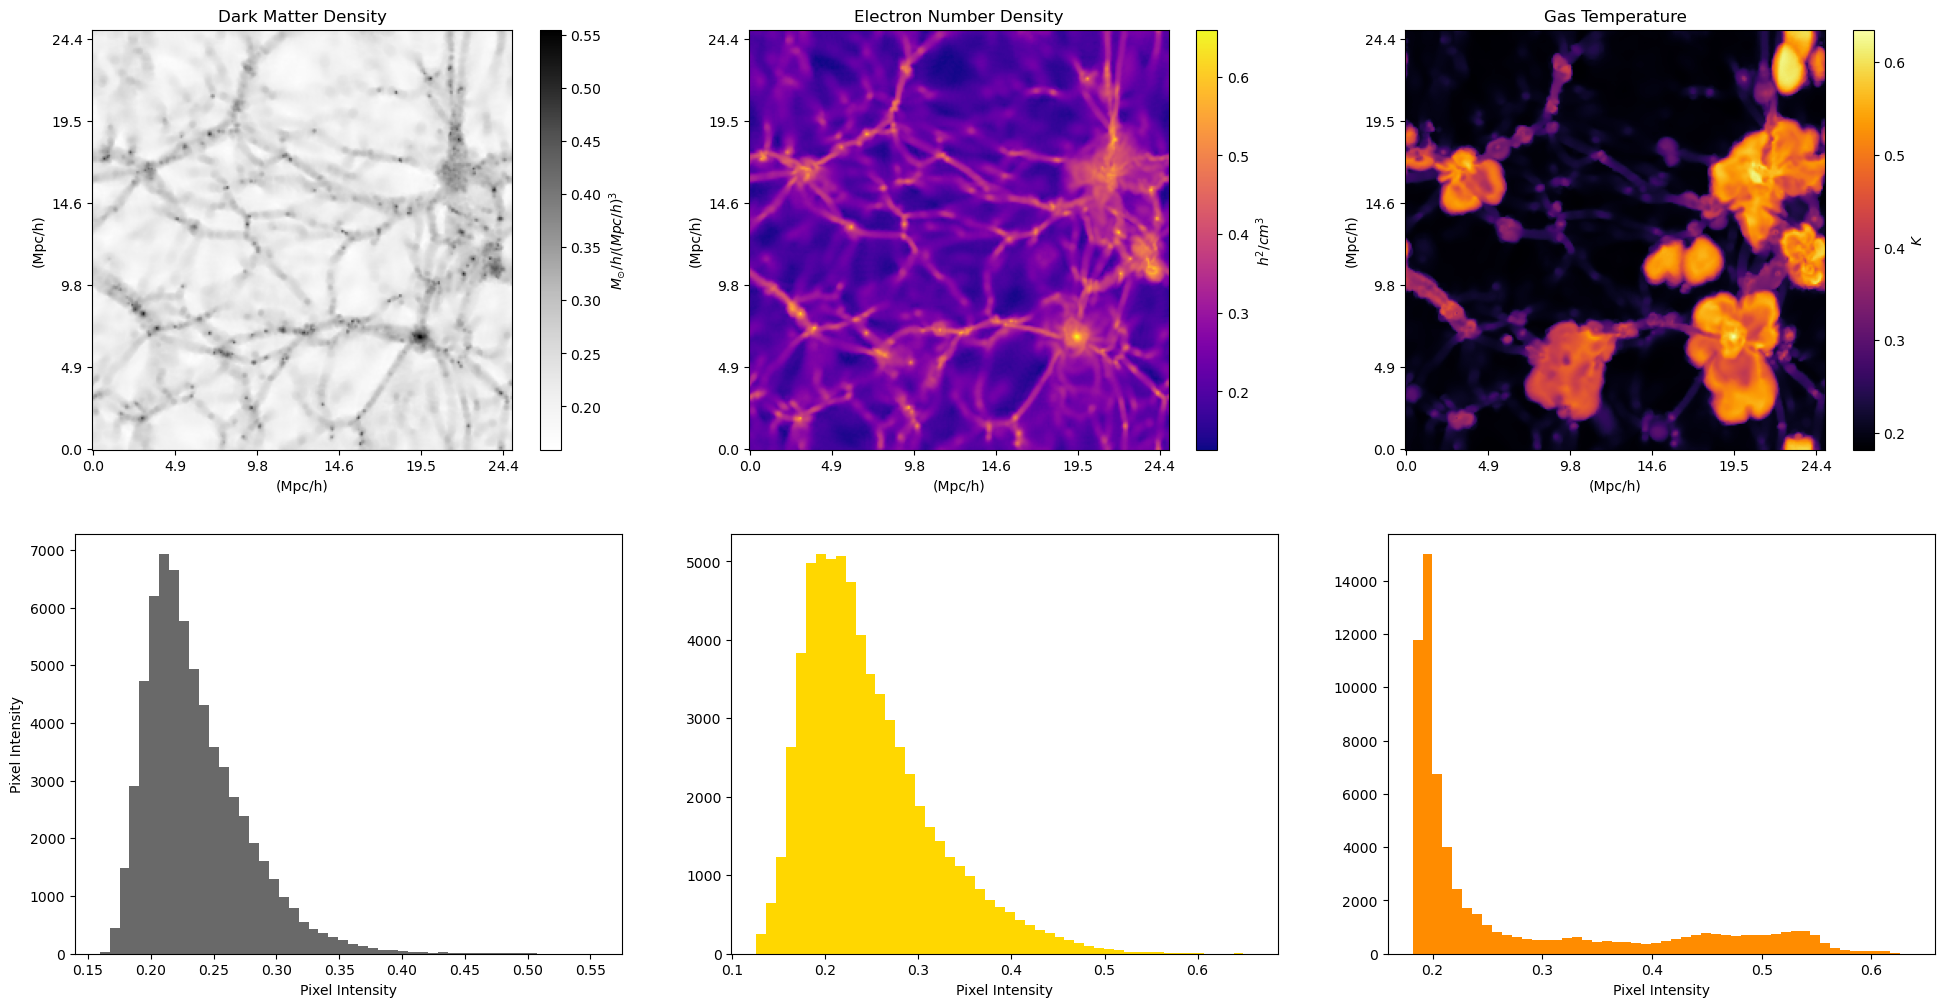

In [172]:
def plot_XYpair(image1, image2, image3):
    """Plots the ith slice of the a 3D grid."""

    # Creating figure, axis and image,
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    img1 = axes[0, 0].imshow(image1, cmap="Greys")
    img2 = axes[0, 1].imshow(image2, cmap="plasma")
    img3 = axes[0, 2].imshow(image3, cmap="inferno")

    # Setting labels,
    axes[0, 0].set_xlabel("(Mpc/h)")
    axes[0, 0].set_ylabel("(Mpc/h)")
    axes[0, 0].set_title(input_QUANTITY)

    axes[0, 1].set_xlabel("(Mpc/h)")
    axes[0, 1].set_ylabel("(Mpc/h)")
    axes[0, 1].set_title(target1_QUANTITY)

    axes[0, 2].set_xlabel("(Mpc/h)")
    axes[0, 2].set_ylabel("(Mpc/h)")
    axes[0, 2].set_title(target2_QUANTITY)

    # Custom xtick and ytick labels,
    def custom_formatter(x, pos):
        return f'{x * (25/256):.1f}'

    # Setting formatter,
    FORMATTER = FuncFormatter(custom_formatter)
    for ax in axes[0]:
        ax.xaxis.set_major_formatter(FORMATTER)
        ax.yaxis.set_major_formatter(FORMATTER)
        ax.invert_yaxis()

    # Adding colorbars,
    cbar1 = plt.colorbar(img1, ax=axes[0, 0], orientation="vertical")
    cbar1.set_label(input_UNITS)
    cbar2 = plt.colorbar(img2, ax=axes[0, 1], orientation="vertical")
    cbar2.set_label(target1_UNITS)
    cbar3 = plt.colorbar(img3, ax=axes[0, 2], orientation="vertical")
    cbar3.set_label(target2_UNITS)

    # Plotting histograms,
    axes[1, 0].hist(image1.flatten(), bins=50, color='dimgrey')
    axes[1, 0].set_xlabel("Pixel Intensity")
    axes[1, 0].set_ylabel("Pixel Intensity")

    axes[1, 1].hist(image2.flatten(), bins=50, color='gold')
    axes[1, 1].set_xlabel(target1_UNITS)
    axes[1, 1].set_xlabel("Pixel Intensity")

    axes[1, 2].hist(image3.flatten(), bins=50, color='darkorange')
    axes[1, 2].set_xlabel(target2_UNITS)
    axes[1, 2].set_xlabel("Pixel Intensity")

    # Showing plot,
    #plt.tight_layout()
    plt.show()

"""VISUALISATION"""
i = 78
plot_XYpair(X[i], Y1[i], Y2[i])


# Stage 2 - Training, Testing and Validation Split

In [ ]:
# Defining the split,
TRAIN_PROP = 0.95
VALIDATION_PROP = 0.01 
TEST_PROP = 0.04 
RANDOM_STATE = 42

# Creating explicit indices,
data_length = X.shape[0]
data_indices = np.arange(start = 0, stop = data_length, step = 1)

# Shuffling the indices,
np.random.shuffle(data_indices)

# Split indices into train and temp (val+test),
train_indices, temp_indices = train_test_split(data_indices, test_size = (VALIDATION_PROP + TEST_PROP), random_state = RANDOM_STATE)

# Further split temp into validation and test,
val_indices, test_indices = train_test_split(temp_indices, test_size = (TEST_PROP/(VALIDATION_PROP + TEST_PROP)), random_state = RANDOM_STATE)

# Creating training, testing and validation data,
X_train, Y1_train, Y2_train, redshifts_train = X[train_indices], Y1[train_indices], Y2[train_indices], redshift_labels[train_indices]
X_test, Y1_test, Y2_test, redshifts_test = X[test_indices], Y1[test_indices], Y2[test_indices], redshift_labels[test_indices]
X_val, Y1_val, Y2_val, redshifts_val = X[val_indices], Y1[val_indices], Y2[val_indices], redshift_labels[val_indices]

# Stage 3 - Create TF Datasets

In [ ]:
# Saving to dataset to record files,
save_to_tfrecord(X_train, Y1_train, redshifts_train, f"MINItraining_dataset(DMP-Ne).tfrecord")
save_to_tfrecord(X_test, Y1_test, redshifts_test, f"MINItesting_dataset(DMP-Ne).tfrecord")
save_to_tfrecord(X_val, Y1_val, redshifts_val, f"MINIvalidation_dataset(DMP-Ne).tfrecord")

save_to_tfrecord(X_train, Y2_train, redshifts_train, f"MINItraining_dataset(DMP-T).tfrecord")
save_to_tfrecord(X_test, Y2_test, redshifts_test, f"MINItesting_dataset(DMP-T).tfrecord")
save_to_tfrecord(X_val, Y2_val, redshifts_val, f"MINIvalidation_dataset(DMP-T).tfrecord")

Saved: MINItraining_dataset(DMP-Ne).tfrecord
Saved: MINItesting_dataset(DMP-Ne).tfrecord
Saved: MINIvalidation_dataset(DMP-Ne).tfrecord
Saved: MINItraining_dataset(DMP-T).tfrecord
Saved: MINItesting_dataset(DMP-T).tfrecord
Saved: MINIvalidation_dataset(DMP-T).tfrecord


# Transfer Learning

In [13]:
"""DATA LOADING"""

# Loading input data files,
X = np.load(r"..//CAMELs//N-body_EX//Grids_Mtot_Nbody_IllustrisTNG_EX_256_z=0.0.npy", mmap_mode='r')

# Loading target data files,
Y1 = np.load(r"..//CAMELs//IllustrisTNG_EX//Grids_ne_IllustrisTNG_EX_256_z=0.0.npy", mmap_mode='r')
Y2 = np.load(r"..//CAMELs//IllustrisTNG_EX//Grids_T_IllustrisTNG_EX_256_z=0.0.npy", mmap_mode='r')

# Selecting the second simulation,
j = 1
X, Y1, Y2 = X[j], Y1[j], Y2[j]

# Creating redshift labels,
redshift = 0.0
redshift_labels = redshift*np.ones(shape=X.shape[0])

"""STAGE 1: NORMALISATION"""

# Functions,
def MinMaxNorm(data, min_val, max_val):
    return (data - min_val)/(max_val - min_val)

# Applying logarithmic transform,
X, Y1, Y2 = np.log10(X), np.log10(Y1), np.log10(Y2)

# Applying Min-Max normalisation,
X_min, X_max = 4, 17 #(DMD)
Y1_min, Y1_max = -9, -1 #(DMP-Ne)
Y2_min, Y2_max = 2, 9 #(DMP-T)

X, Y1, Y2 = MinMaxNorm(X, X_min, X_max), MinMaxNorm(Y1, Y1_min, Y1_max), MinMaxNorm(Y2, Y2_min, Y2_max)

"""STAGE 2: DATA SPLIT"""

# Defining the split,
TRAIN_PROP = 0.9375 #(15/16)
VALIDATION_PROP = 0.03125 #(1/32)
TEST_PROP = 0.03125 #(1/32)
RANDOM_STATE = 42

# Creating explicit indices,
data_length = X.shape[0]
data_indices = np.arange(start = 0, stop = data_length, step = 1)

# Shuffling the indices,
np.random.shuffle(data_indices)

# Split indices into train and temp (val+test),
train_indices, temp_indices = train_test_split(data_indices, test_size = (VALIDATION_PROP + TEST_PROP), random_state = RANDOM_STATE)

# Further split temp into validation and test,
val_indices, test_indices = train_test_split(temp_indices, test_size = (TEST_PROP/(VALIDATION_PROP + TEST_PROP)), random_state = RANDOM_STATE)

# Creating training, testing and validation data,
X_train, Y1_train, Y2_train, redshifts_train = X[train_indices], Y1[train_indices], Y2[train_indices], redshift_labels[train_indices]
X_test, Y1_test, Y2_test, redshifts_test = X[test_indices], Y1[test_indices], Y2[test_indices], redshift_labels[test_indices]
X_val, Y1_val, Y2_val, redshifts_val = X[val_indices], Y1[val_indices], Y2[val_indices], redshift_labels[val_indices]

"""STAGE 3: CREATE TF DATASETS"""

# Saving to dataset to record files,
save_to_tfrecord(X_train, Y1_train, redshifts_train, f"training(TRANSFER)_dataset(DMP-Ne).tfrecord")
save_to_tfrecord(X_test, Y1_test, redshifts_test, f"testing(TRANSFER)_dataset(DMP-Ne).tfrecord")
save_to_tfrecord(X_val, Y1_val, redshifts_val, f"validation(TRANSFER)_dataset(DMP-Ne).tfrecord")

save_to_tfrecord(X_train, Y2_train, redshifts_train, f"training(TRANSFER)_dataset(DMP-T).tfrecord")
save_to_tfrecord(X_test, Y2_test, redshifts_test, f"testing(TRANSFER)_dataset(DMP-T).tfrecord")
save_to_tfrecord(X_val, Y2_val, redshifts_val, f"validation(TRANSFER)_dataset(DMP-T).tfrecord")

Saved: training(TRANSFER)_dataset(DMP-Ne).tfrecord
Saved: testing(TRANSFER)_dataset(DMP-Ne).tfrecord
Saved: validation(TRANSFER)_dataset(DMP-Ne).tfrecord
Saved: training(TRANSFER)_dataset(DMP-T).tfrecord
Saved: testing(TRANSFER)_dataset(DMP-T).tfrecord
Saved: validation(TRANSFER)_dataset(DMP-T).tfrecord
